<a href="https://colab.research.google.com/github/theHoodguy4587/Sri-Lanka-Student-Risk-Prediction/blob/main/Sri_Lanka_Student_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd

from google.colab import files
uploaded=files.upload()

df=pd.read_csv('student-mat.csv',sep=';')
df.head()

Saving student-mat.csv to student-mat.csv


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
df.isnull().sum()

,0
school,0
sex,0
age,0
address,0
famsize,0
Pstatus,0
Medu,0
Fedu,0
Mjob,0
Fjob,0


Adding a new feature 'risk'

In [4]:
df['risk']=df['G3'].apply(lambda x:'at risk' if x<10 else 'safe')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,risk
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,at risk
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,at risk
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,safe
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,safe
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,safe


Encode categorical variables

In [5]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

for col in df.select_dtypes(include=['object']):
  df[col]=le.fit_transform(df[col])

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,risk
0,0,0,18,1,0,0,4,4,0,4,...,3,4,1,1,3,6,5,6,6,0
1,0,0,17,1,0,1,1,1,0,2,...,3,3,1,1,3,4,5,5,6,0
2,0,0,15,1,1,1,1,1,0,2,...,3,2,2,3,3,10,7,8,10,1
3,0,0,15,1,0,1,4,2,1,3,...,2,2,1,1,5,2,15,14,15,1
4,0,0,16,1,0,1,3,3,2,2,...,3,2,1,2,5,4,6,10,10,1


split the data set

In [6]:
X=df.drop(['risk','G3'],axis=1)
y=df['risk']

Use postgres sql

In [7]:
import sqlite3
import pandas as pd


conn = sqlite3.connect('student_risk.db')
cur = conn.cursor()

df.to_sql('students', conn, if_exists='replace', index=False)


395

Total Number of risk students

In [8]:
pd.read_sql("SELECT COUNT(*) as at_risk_count FROM students WHERE risk='1';", conn)

,at_risk_count
0,265


Average study time by risk

In [9]:
pd.read_sql(""" SELECT CASE WHEN risk='1' THEN 'at risk' ELSE 'Safe' END AS risk,AVG(studytime) AS avg_studytime FROM students GROUP BY risk;""", conn)

,risk,avg_studytime
0,Safe,1.946154
1,at risk,2.079245


Count of risk students by gender

In [10]:
pd.read_sql(""" SELECT CASE WHEN sex='1' THEN 'Male' ELSE 'Female' END AS gender,COUNT(*) AS risk_count FROM students WHERE risk='1' GROUP BY sex;""", conn)

,gender,risk_count
0,Female,133
1,Male,132


Distribution by parental status

In [11]:
pd.read_sql(""" SELECT CASE WHEN Pstatus='1' THEN 'Living together' ELSE 'Apart' END AS status,COUNT(*) AS risk_count FROM students WHERE risk='1' GROUP BY Pstatus;""", conn)

,status,risk_count
0,Apart,30
1,Living together,235


Train test split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logred_pred=logreg.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
print(" Logistic regression Accuracy: ",accuracy_score(y_test, logred_pred))
print(classification_report(y_test, logred_pred))
print(confusion_matrix(y_test,logred_pred))

 Logistic regression Accuracy:  0.8734177215189873
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        26
           1       0.96      0.85      0.90        53

    accuracy                           0.87        79
   macro avg       0.85      0.89      0.86        79
weighted avg       0.89      0.87      0.88        79

[[24  2]
 [ 8 45]]


Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=200,random_state=42,class_weight='balanced')
rf.fit(X_train,y_train)
y_pred_rf=rf.predict(X_test)

In [22]:
print("Random Forest Accuracy: ",accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test,y_pred_rf))

Random Forest Accuracy:  0.8734177215189873
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        26
           1       0.96      0.85      0.90        53

    accuracy                           0.87        79
   macro avg       0.85      0.89      0.86        79
weighted avg       0.89      0.87      0.88        79

[[24  2]
 [ 8 45]]


Roc Curve

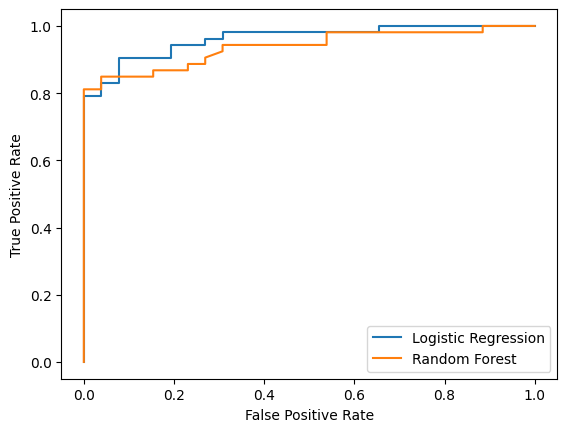

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_lr,tpr_lr,_=roc_curve(y_test,logreg.predict_proba(X_test)[:,1])
fpr_rf,tpr_rf,_=roc_curve(y_test,rf.predict_proba(X_test)[:,1])

plt.plot(fpr_lr,tpr_lr,label='Logistic Regression')
plt.plot(fpr_rf,tpr_rf,label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Feature Importance

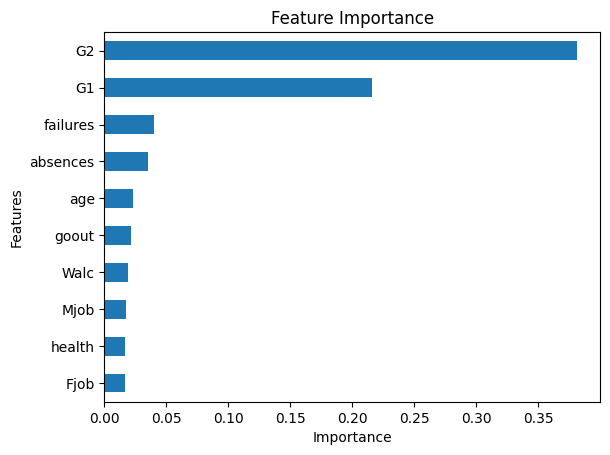

In [29]:
importances=pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=True).tail(10).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


In [30]:
import pickle

with open("student_risk_model.pkl", "wb") as f:
    pickle.dump(logreg, f)


In [31]:
with open("features.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)
